# Part1: Theory Questions

## 1. Three approaches to characterizing the texture in an image

### 1) GLCM (Gray Level Co-occurance Matrix)

- GLCM measures the joint probability of the grayscale values in an image P(x1, x2).
- Basically, we calculate different combinations of pixel brightness values (grey levels) occur for two pixels with the fixed relative spatial position in an image. 
- GLMC matrix is of the shape (N,N), where N is the number of distinct pixel values.

### 2) LBP (Local Binary Pattern)

- LBP characterize the grayscale variations around a pixel through runs of '0' and '1'.
- LBP calculate the relative pixel value on a circle centered at the current pixel. The pixel value on the circle is calculated based on bilibear interpolation.  
- LBP is invariant to in-plane rotation, as it circularly rotate the binary pattern till it acquires the smallest correponding integer value. 


### 3) Gabor filter

- Gabor filter measures the periodicities at different frequencies in different directions for an image.
- The calculation is based on localized furier transform.
- The logic is that many image textures are composed of repetitively ocurring micro-patterns.

## 2. Right or Wrong



### 1) RGB and HSI are just linear variants of each other

- Wrong
- HSI are calculately with RGB based on non-linear equation. 

### 2) The color space L*a*b* is a nonlinear model of color perception.

- Right
- Each of the three axises is nonlinear. It is intended to mimic the nonlinear response of the visual system

### 3) Measuring the true color of the surface of an object is made diffcult by the spectral composition of the illumination.

- Right
- The measured color on the dector depends on the illumination spectrum composition.
- The true color of a surface can be measured if the illumination is fixed. But in reality, the illumination is complex and not fixed.

# Part2: Program task

## Comment:

### 1. For the three method: channell normalization parameter works best (0.975), follows by GRAM (0.895), then LBP (0.715)

### 2. Limited by the computation power, we only use a small subset of the GRAM matrix, I believe the accuracy wiil be better if a larger subset or the whole matrix is used to train the classifier.

### 3. LBP is doesn't work good enough as currently we only have 8 parameters. The model is too simple and has a large bais.

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from numpy.linalg import inv
from numpy import linalg as LA
import math
from random import sample
from scipy.optimize import least_squares
import glob
import BitVector
import numpy as np
import torch
import torch.nn as nn
from sklearn import svm
from sklearn.metrics import confusion_matrix

## Explore the data 

In [83]:
project_path = 'F:/Python/Computer_Vision/HW7'
os.chdir(project_path)

In [91]:
weather_condi = ['cloudy','rain','shine','sunrise']

train_files = []
test_files = []

for i in weather_condi:
    train_files.append(glob.glob(project_path+'/data/training/'+ i +'*'))
    test_files.append(glob.glob(project_path+'/data/testing/'+ i +'*'))

# train_files = glob.glob(project_path+'/data/training/'+'cloudy'+'*')
# test_files = glob.glob(project_path+'/data/testing/*')

Text(0.5, 1.0, 'F:/Python/Computer_Vision/HW7/data/training\\cloudy1.jpg')

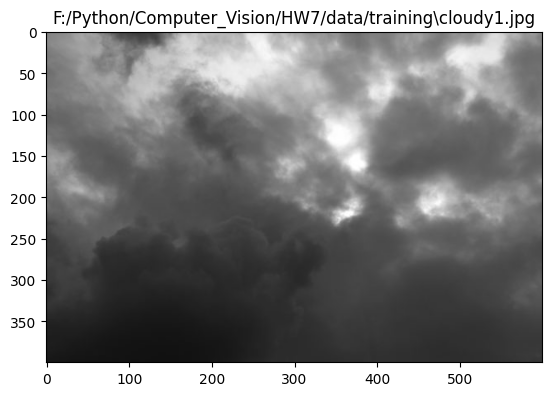

In [4]:
img = cv.imread(train_files[0][0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(train_files[0][0])

## LBP: feature vector

In [5]:
# normalize the image to 64x64 grayscale image
def gray_resize(path):
    img = cv.imread(path)
    # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # plt.figure()
    # plt.imshow(img_gray)
    img_resize = cv.resize(img_gray, (64, 64))
    # plt.figure()
    # plt.imshow(img_resize)
    
    return img_resize

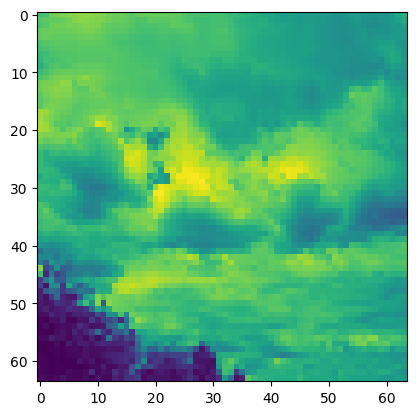

In [6]:
plt.imshow(gray_resize(train_files[0][1]))

In [7]:
R = 1 # radius of the circle

# only consider P = 8
P = 8 # num of points on the circle: 


lbp_hist = {t:0 for t in range(8+2)} # index represent the encode
# lbp_map = [[0]*64]*64

img = gray_resize(train_files[0][1])
img_shape = img.shape

for i in range(R,img_shape[0]-R):
    for j in range(R,img_shape[1]-R):
        pattern = [0]*8
        temp_mat = img[i-1:i+2,j-1:j+2]
        
        pattern[0] = temp_mat[0,1]
        pattern[1] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[0,1]*(1-0.707)*0.707 +  temp_mat[1,2]*(1-0.707)*0.707 + temp_mat[0,2]*0.707*0.707
        pattern[2] = temp_mat[1,2]
        pattern[3] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[2,1]*(1-0.707)*0.707 +  temp_mat[1,2]*(1-0.707)*0.707 + temp_mat[2,2]*0.707*0.707
        pattern[4] = temp_mat[2,1]
        pattern[5] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[2,1]*(1-0.707)*0.707 +  temp_mat[1,0]*(1-0.707)*0.707 + temp_mat[2,0]*0.707*0.707
        pattern[6] = temp_mat[1,0]
        pattern[7] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[0,1]*(1-0.707)*0.707 +  temp_mat[1,0]*(1-0.707)*0.707 + temp_mat[0,0]*0.707*0.707
        
        pattern_bit = (pattern > temp_mat[1,1]).astype(int)
        
        bit_vector = BitVector.BitVector(bitlist = pattern_bit)
        shift_circular = [int(bit_vector>>1) for i in range(P)]
        
        min_bv = BitVector.BitVector(intVal = min(shift_circular), size = P)
        bv_run = min_bv.runs()
        
        if len(bv_run) > 2:
            lbp_hist[P+1] += 1
        elif len(bv_run) == 1:
            if bv_run[0][0] == '1':
                lbp_hist[P] += 1
            else:
                lbp_hist[0] += 1
        else:
            lbp_hist[len(bv_run[1])] += 1
        
print(lbp_hist)

{0: 235, 1: 258, 2: 294, 3: 665, 4: 888, 5: 533, 6: 208, 7: 256, 8: 157, 9: 350}


In [8]:
def lbp_hist_cal(path, P, R):
    R = 1 # radius of the circle

    # only consider P = 8
    P = 8 # num of points on the circle: 


    lbp_hist = {t:0 for t in range(8+2)} # index represent the encode
    # lbp_map = [[0]*64]*64

    img = gray_resize(path)
    img_shape = img.shape

    for i in range(R,img_shape[0]-R):
        for j in range(R,img_shape[1]-R):
            pattern = [0]*8
            temp_mat = img[i-1:i+2,j-1:j+2]
        
            pattern[0] = temp_mat[0,1]
            pattern[1] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[0,1]*(1-0.707)*0.707 +  temp_mat[1,2]*(1-0.707)*0.707 + temp_mat[0,2]*0.707*0.707
            pattern[2] = temp_mat[1,2]
            pattern[3] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[2,1]*(1-0.707)*0.707 +  temp_mat[1,2]*(1-0.707)*0.707 + temp_mat[2,2]*0.707*0.707
            pattern[4] = temp_mat[2,1]
            pattern[5] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[2,1]*(1-0.707)*0.707 +  temp_mat[1,0]*(1-0.707)*0.707 + temp_mat[2,0]*0.707*0.707
            pattern[6] = temp_mat[1,0]
            pattern[7] = temp_mat[1,1]*(1-0.707)*(1-0.707) + temp_mat[0,1]*(1-0.707)*0.707 +  temp_mat[1,0]*(1-0.707)*0.707 + temp_mat[0,0]*0.707*0.707
        
            pattern_bit = (pattern > temp_mat[1,1]).astype(int)
        
            bit_vector = BitVector.BitVector(bitlist = pattern_bit)
            shift_circular = [int(bit_vector>>1) for i in range(P)]
        
            min_bv = BitVector.BitVector(intVal = min(shift_circular), size = P)
            bv_run = min_bv.runs()
        
            if len(bv_run) > 2:
                lbp_hist[P+1] += 1
            elif len(bv_run) == 1:
                if bv_run[0][0] == '1':
                    lbp_hist[P] += 1
                else:
                    lbp_hist[0] += 1
            else:
                lbp_hist[len(bv_run[1])] += 1
    return lbp_hist

cloudy lbp_hist ->>> {0: 172, 1: 213, 2: 325, 3: 782, 4: 1001, 5: 666, 6: 233, 7: 134, 8: 67, 9: 251}
rain lbp_hist ->>> {0: 591, 1: 373, 2: 198, 3: 162, 4: 176, 5: 219, 6: 228, 7: 452, 8: 542, 9: 903}
shine lbp_hist ->>> {0: 272, 1: 270, 2: 171, 3: 832, 4: 1037, 5: 426, 6: 120, 7: 186, 8: 185, 9: 345}
sunrise lbp_hist ->>> {0: 145, 1: 166, 2: 222, 3: 868, 4: 1362, 5: 441, 6: 189, 7: 151, 8: 75, 9: 225}


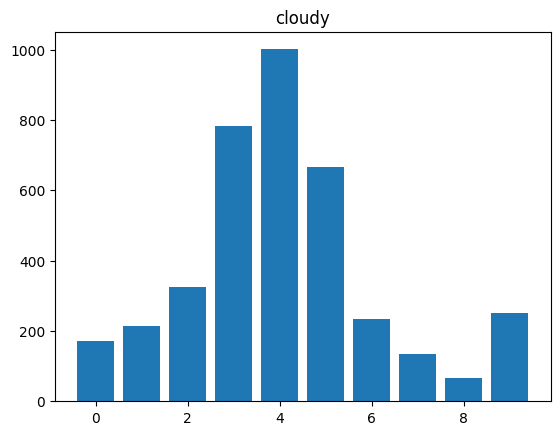

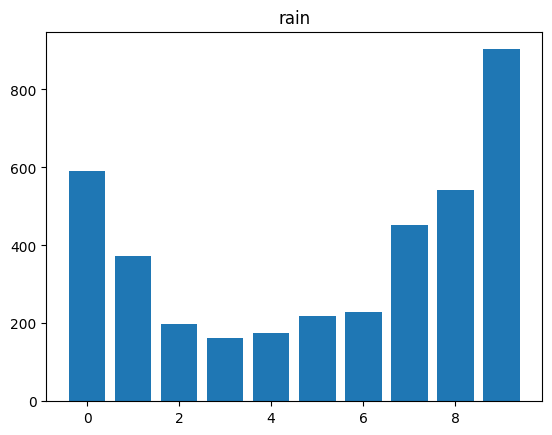

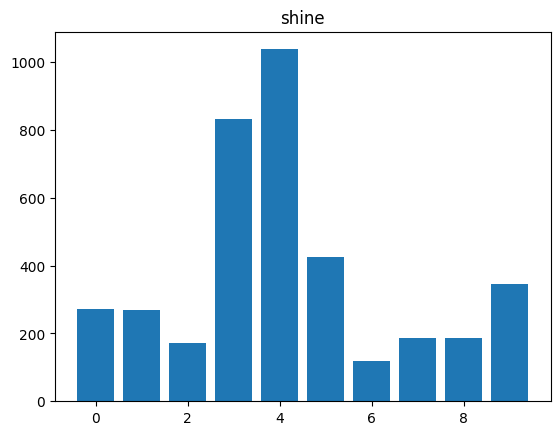

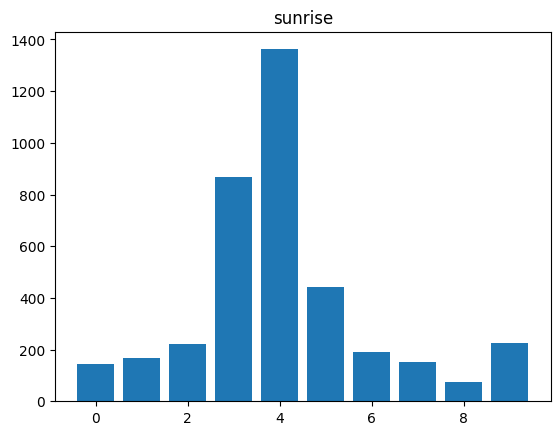

In [128]:
for i in range(4):
    res = lbp_hist_cal(train_files[i][0],8,1)
    print(weather_condi[i] + ' lbp_hist ->>>', lbp_hist_cal(train_files[i][0],8,1))
    plt.figure()
    plt.bar(list(res.keys()), list(res.values()))
    plt.title(weather_condi[i])

## LBP: prepare train and test dataset

In [101]:
train_lbp_x = []
train_lbp_y = []

for i in range(0,len(train_files)):
    for j in train_files[i]:
        train_lbp_x.append(list(lbp_hist_cal(j,8,1).values()))
        train_lbp_y.append(i)
        
train_lbp_x = np.array(train_lbp_x)
train_lbp_y = np.array(train_lbp_y)     

In [ ]:
test_lbp_x = []
test_lbp_y = []

for i in range(0,len(test_files)):
    for j in test_files[i]:
        test_lbp_x.append(list(lbp_hist_cal(j,8,1).values()))
        test_lbp_y.append(i)

        
test_lbp_x = np.array(test_lbp_x)
test_lbp_y = np.array(test_lbp_y)          

## GRAM: SVM multi-class classifier

In [120]:
clf_lbp = svm.SVC(decision_function_shape='ovo')
clf_lbp.fit(train_lbp_x, train_lbp_y)

predict_lbp = clf_lbp.predict(test_lbp_x)
accuracy_lbp =  sum(np.diag(confusion_matrix(predict_lbp, test_lbp_y)/50))/4

print('LBP: accuracy of the classifer ->> \n',accuracy_lbp)
print('LBP: confusion matrix ->> \n',confusion_matrix(predict_lbp, test_lbp_y))

LBP: accuracy of the classifer ->> 
 0.715
LBP: confusion matrix ->> 
 [[41  0 18  4]
 [ 0 43  0  0]
 [ 2  0 13  0]
 [ 7  7 19 46]]


## Gram Matrix: feature vector

In [15]:
class VGG19(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # encode 1-1
            nn.Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),  # relu 1-1
            # encode 2-1
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),  # relu 2-1
            # encoder 3-1
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),  # relu 3-1
            # encoder 4-1
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),  # relu 4-1
            # rest of vgg not used
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),  # relu 5-1
            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            # nn.ReLU(inplace=True)
        )

    def load_weights(self, path_to_weights):
        vgg_model = torch.load(path_to_weights)
        # Don't care about the extra weights
        self.model.load_state_dict(vgg_model, strict=False)
        for parameter in self.model.parameters():
            parameter.requires_grad = False

    def forward(self, x):
        # Input is numpy array of shape (H, W, 3)
        # Output is numpy array of shape (N_l, H_l, W_l)
        x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0).float()
        out = self.model(x)
        out = out.squeeze(0).numpy()
        return out

In [107]:
from skimage import io, transform
def gram_matrix_cal(path):
    vgg = VGG19()
    vgg.load_weights('vgg_normalized.pth')
    
    # Read an image into numpy array
    x = io.imread(path)
    
    # Resize the input image
    x = transform.resize(x, (256, 256))
    
    # Obtain the output feature map
    ft = vgg(x)
    
    #print(ft.shape)
    channel_vect = ft.reshape((512, 256))
    gram_mat = np.matmul(channel_vect,channel_vect.T)
    
    random_num = 10000
    gram_vect = gram_mat.flatten()[random_num:random_num+1024]
    
    return gram_mat,gram_vect

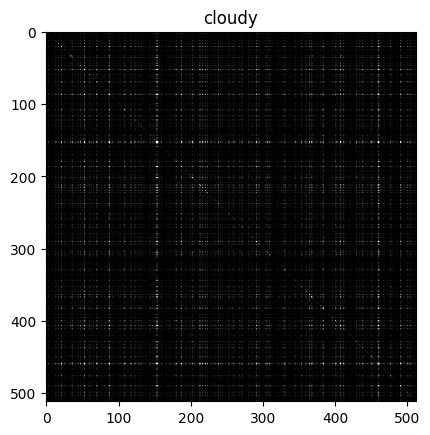

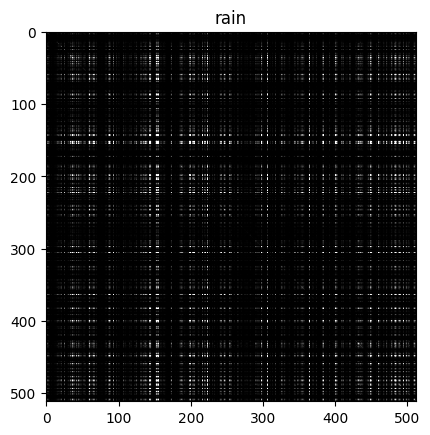

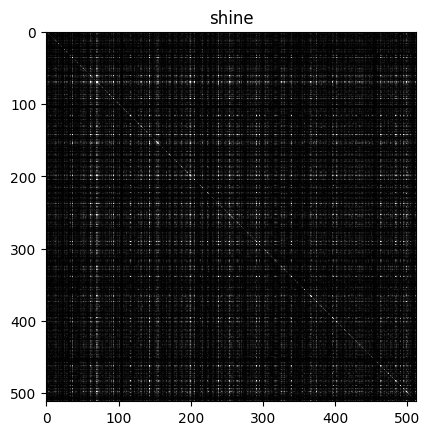

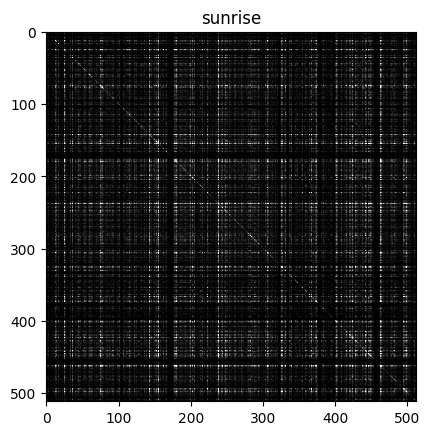

In [54]:
for i in range(4):
    
    gram_mat, gram_vect = gram_matrix_cal(train_files[i][0])
    plt.figure()
    plt.imshow(gram_mat,cmap='gray', vmin=gram_mat.min(), vmax=gram_mat.max()/10)
    plt.title(weather_condi[i])
    # list(gram_vect)

## GRAM: prepare train and test dataset

In [93]:
train_gram_x = []
train_gram_y = []

for i in range(0,len(train_files)):
    for j in train_files[i]:
        # print(j,'Start')
        gram_mat, gram_vect = gram_matrix_cal(j)
        train_gram_x.append(list(gram_vect))
        train_gram_y.append(i)
        # print(j,'Done')

train_gram_x = np.array(train_gram_x)
train_gram_y = np.array(train_gram_y)

In [94]:
test_gram_x = []
test_gram_y = []

for i in range(0,len(test_files)):
    for j in test_files[i]:
        gram_mat, gram_vect = gram_matrix_cal(j)
        test_gram_x.append(list(gram_vect))
        test_gram_y.append(i)

test_gram_x = np.array(test_gram_x)
test_gram_y = np.array(test_gram_y)

In [96]:
test_gram_x.shape

(200, 1024)

## GRAM: SVM multi-class classifier

In [121]:
clf_gram = svm.SVC(decision_function_shape='ovo')
clf_gram.fit(train_gram_x, train_gram_y)

predict_gram = clf_gram.predict(test_gram_x)
accuracy_gram =  sum(np.diag(confusion_matrix(predict_gram, test_gram_y)/50))/4

print('GRAM: accuracy of the classifer ->> \n',accuracy_gram)
print('GRAM: confusion matrix ->> \n',confusion_matrix(predict_gram, test_gram_y))

GRAM: accuracy of the classifer ->> 
 0.895
GRAM: confusion matrix ->> 
 [[47  0  5  1]
 [ 0 50  4  0]
 [ 1  0 33  0]
 [ 2  0  8 49]]


## Extra Credit: Channel normalization parameters based dsecriptor (CNP)


In [111]:
from skimage import io, transform

def cnp_matrix_cal(path):
    vgg = VGG19()
    vgg.load_weights('vgg_normalized.pth')
    
    # Read an image into numpy array
    x = io.imread(path)
    
    # Resize the input image
    x = transform.resize(x, (256, 256))
    
    # Obtain the output feature map
    ft = vgg(x)
    
    #print(ft.shape)
    channel_vect = ft.reshape((512, 256))
    cnp_vect = [0]*512*2
    for i in range(len(channel_vect)):
        # mean
        cnp_vect[2*i] = np.mean(channel_vect[i])
        # std
        cnp_vect[2*i+1] = np.std(channel_vect[i])
    
    return cnp_vect

In [118]:
# cnp_matrix_cal(train_files[0][0])

## CNP: prepare train and test dataset

In [117]:
train_cnp_x = []
train_cnp_y = []

for i in range(0,len(train_files)):
    for j in train_files[i]:
        # print(j,'Start')
        cnp_vect = cnp_matrix_cal(j)
        train_cnp_x.append(cnp_vect)
        train_cnp_y.append(i)
        # print(j,'Done')

train_cnp_x = np.array(train_cnp_x)
train_cnp_y = np.array(train_cnp_y)

In [122]:
test_cnp_x = []
test_cnp_y = []

for i in range(0,len(test_files)):
    for j in test_files[i]:
        # print(j,'Start')
        cnp_vect = cnp_matrix_cal(j)
        test_cnp_x.append(cnp_vect)
        test_cnp_y.append(i)
        # print(j,'Done')

test_cnp_x = np.array(test_cnp_x)
test_cnp_y = np.array(test_cnp_y)

## CNP: SVM multi-class classifier

In [123]:
clf_cnp = svm.SVC(decision_function_shape='ovo')
clf_cnp.fit(train_cnp_x, train_cnp_y)

SVC(decision_function_shape='ovo')

In [126]:
predict_cnp = clf_cnp.predict(test_cnp_x)
accuracy_cnp =  sum(np.diag(confusion_matrix(predict_cnp, test_cnp_y)/50))/4

print('CNP: accuracy of the classifer ->> \n',accuracy_cnp)
print('CNP: confusion matrix ->> \n',confusion_matrix(predict_cnp, test_cnp_y))

CNP: accuracy of the classifer ->> 
 0.975
CNP: confusion matrix ->> 
 [[49  0  2  0]
 [ 0 50  0  0]
 [ 1  0 46  0]
 [ 0  0  2 50]]
